<a href="https://colab.research.google.com/github/datascience-uniandes/hypothesis-testing-tutorial/blob/master/hypothesis-testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML - Supermercados Inteligentes

Univerisdad de los Andes MINE-4101: Applied Data Science  

- Lizeth Viviana Perdomo Castañeda
- David Esteban Fajardo Torres
  
**Dataset:** Dataset abierto de varios productos de mercado con sus etiquetas para identificar el tipo de productos. [dataset](https://github.com/marcusklasson/GroceryStoreDataset/tree/master/dataset).

**Business Context:** Los supermercados inteligentes están diseñados para mejorar todos los aspectos del proceso de compra, desde la entrada del cliente hasta la salida, utilizando tecnologías avanzadas para automatizar tareas, gestionar inventarios en tiempo real y analizar el comportamiento del consumidor.

Un nuevo supermercado inteligente, ha implementado tecnologías avanzadas como sensores y cámaras. Para iniciar la automatización de procesos, ahora necesita aprovechar mejor los datos generados a diario para tomar decisiones más informadas y eficaces.

El supermercado requiere el desarrollo de un sistema de automatización que permita a los clientes tomar productos y salir sin pasar por caja, mientras las cámaras y sensores registran automáticamente los artículos seleccionados.


In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


The filename, directory name, or volume label syntax is incorrect.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

### Carga y exploración del Dataset

In [3]:
base_dir = r'C:\Users\lperd\OneDrive - Universidad de los andes\MINE 2024-2\CIENCIA DE DATOS APLICADA\Talleres\Taller 2\GroceryStoreDataset\new_dataset'
#base_dir = r'C:\Users\Esteban\Documents\MINE\GroceryStoreDataset\new_dataset'


In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print(train_dir)


C:\Users\Esteban\Documents\MINE\GroceryStoreDataset\new_dataset\train


In [5]:
# Aumento de datos solo para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [6]:
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Generadores de imágenes
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
val_labels = val_generator.classes  # Etiquetas verdaderas

print(train_generator.class_indices)

Found 1996 images belonging to 60 classes.
Found 296 images belonging to 60 classes.
Found 1889 images belonging to 60 classes.
{'Alpro-Blueberry-Soyghurt': 0, 'Alpro-Vanilla-Soyghurt': 1, 'Arla-Ecological-Medium-Fat-Milk': 2, 'Arla-Medium-Fat-Milk': 3, 'Arla-Mild-Vanilla-Yoghurt': 4, 'Arla-Sour-Cream': 5, 'Arla-Standard-Milk': 6, 'Asparagus': 7, 'Aubergine': 8, 'Avocado': 9, 'Banana': 10, 'Beef-Tomato': 11, 'Bravo-Apple-Juice': 12, 'Bravo-Orange-Juice': 13, 'Brown-Cap-Mushroom': 14, 'Cabbage': 15, 'Cantaloupe': 16, 'Carrots': 17, 'Conference': 18, 'Cucumber': 19, 'Floury-Potato': 20, 'Galia-Melon': 21, 'Garant-Ecological-Medium-Fat-Milk': 22, 'Garant-Ecological-Standard-Milk': 23, 'Ginger': 24, 'God-Morgon-Apple-Juice': 25, 'God-Morgon-Orange-Juice': 26, 'God-Morgon-Orange-Red-Grapefruit-Juice': 27, 'God-Morgon-Red-Grapefruit-Juice': 28, 'Golden-Delicious': 29, 'Granny-Smith': 30, 'Honeydew-Melon': 31, 'Kiwi': 32, 'Leek': 33, 'Lemon': 34, 'Lime': 35, 'Mango': 36, 'Oatly-Natural-Oatghu

In [8]:
def mostrar_imagenes(generator, num_images=5):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()

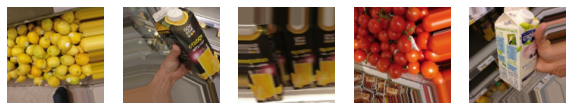

In [9]:
mostrar_imagenes(train_generator)

### Entrenamiento del modelo de Machine Learning

In [10]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

In [11]:
# Modelo CNN básico
def crear_modelo_baseline():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])
    return model

In [12]:
# Entrenar el modelo CNN básico
modelo_baseline = crear_modelo_baseline()
history_baseline = modelo_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.0353 - f1_score: 0.0157 - loss: 4.0831 - precision: 0.0833 - recall: 1.2093e-04 - val_accuracy: 0.0845 - val_f1_score: 0.0161 - val_loss: 3.8301 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.0814 - f1_score: 0.0379 - loss: 3.6443 - precision: 0.3977 - recall: 0.0072 - val_accuracy: 0.0878 - val_f1_score: 0.0278 - val_loss: 3.4199 - val_precision: 0.1250 - val_recall: 0.0034
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.1374 - f1_score: 0.0741 - loss: 3.2679 - precision: 0.4893 - recall: 0.0265 - val_accuracy: 0.1250 - val_f1_score: 0.0503 - val_loss: 3.1671 - val_precision: 0.3750 - val_recall: 0.0101
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.1493 - f1_score: 0.0942 - loss: 3.0480 - precision: 0.4598 - recall: 0.0352 - val_accuracy: 0.1622 - val_f1_score: 0.1067 - val_loss: 2.9457 - val_precision: 0.43

In [13]:
# Modelo de Transfer Learning con MobileNetV2
def crear_modelo_transfer():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False  # Congelar las capas de MobileNetV2
    
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])
    return model

In [14]:
# Entrenar el modelo de Transfer Learning
modelo_transfer = crear_modelo_transfer()
history_transfer = modelo_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.0876 - f1_score: 0.0658 - loss: 4.0534 - precision: 0.2957 - recall: 0.0027 - val_accuracy: 0.2432 - val_f1_score: 0.1788 - val_loss: 3.0583 - val_precision: 0.6667 - val_recall: 0.0135
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.3029 - f1_score: 0.2403 - loss: 2.6524 - precision: 0.6977 - recall: 0.0785 - val_accuracy: 0.3716 - val_f1_score: 0.3256 - val_loss: 2.2719 - val_precision: 0.8500 - val_recall: 0.1149
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.4602 - f1_score: 0.4015 - loss: 1.9404 - precision: 0.7667 - recall: 0.2134 - val_accuracy: 0.4493 - val_f1_score: 0.4059 - val_loss: 1.9510 - val_precision: 0.8313 - val_recall: 0.2331
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.5364 - f1_score: 0.4965 - loss: 1.5406 - precision: 0.7871 - recall: 0.3285 - val_accuracy: 0.4865 - val_f1_score: 0.4371 - val_loss: 1.7336 - val_precision: 0.7593 - val_rec

## Evaluación de los modelos

### Modelo CNN

In [15]:
print("Evaluación del modelo CNN básico:")
baseline_eval = modelo_baseline.evaluate(test_generator)

Evaluación del modelo CNN básico:
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3634 - f1_score: 0.3118 - loss: 1.9458 - precision: 0.5952 - recall: 0.1391


In [37]:
def show_performance_curve(training_result, metric, metric_label):
    train_perf = training_result.history[str(metric)]
    validation_perf = training_result.history['val_'+str(metric)]
    if metric == 'f1_score':
        train_perf = [np.mean(epoch) for epoch in training_result.history[str(metric)]]
        validation_perf = [np.mean(epoch) for epoch in training_result.history['val_'+str(metric)]]
    plt.plot(train_perf, label=metric_label)
    plt.plot(validation_perf, label = 'val_'+str(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric_label)
    plt.legend(loc='lower right')

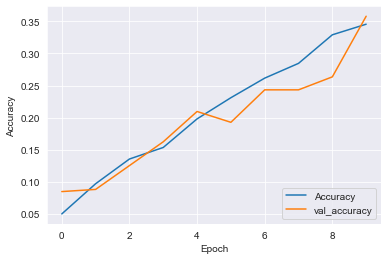

In [38]:
show_performance_curve(history_baseline, metric='accuracy', metric_label='Accuracy')

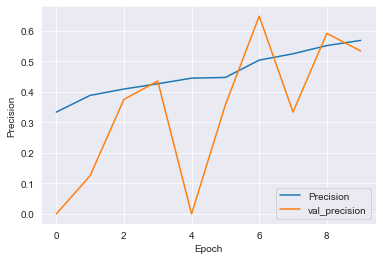

In [18]:
show_performance_curve(history_baseline, metric='precision', metric_label='Precision')

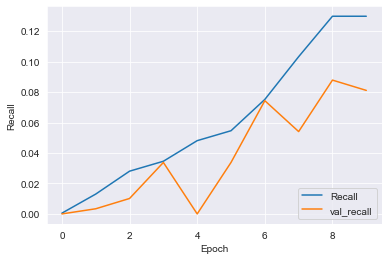

In [19]:
show_performance_curve(history_baseline, metric='recall', metric_label='Recall')

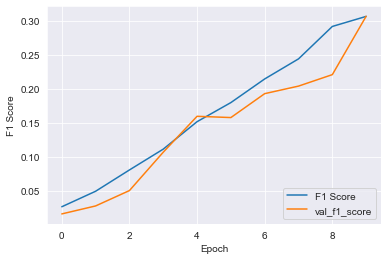

In [20]:
show_performance_curve(history_baseline, metric='f1_score', metric_label='F1 Score')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


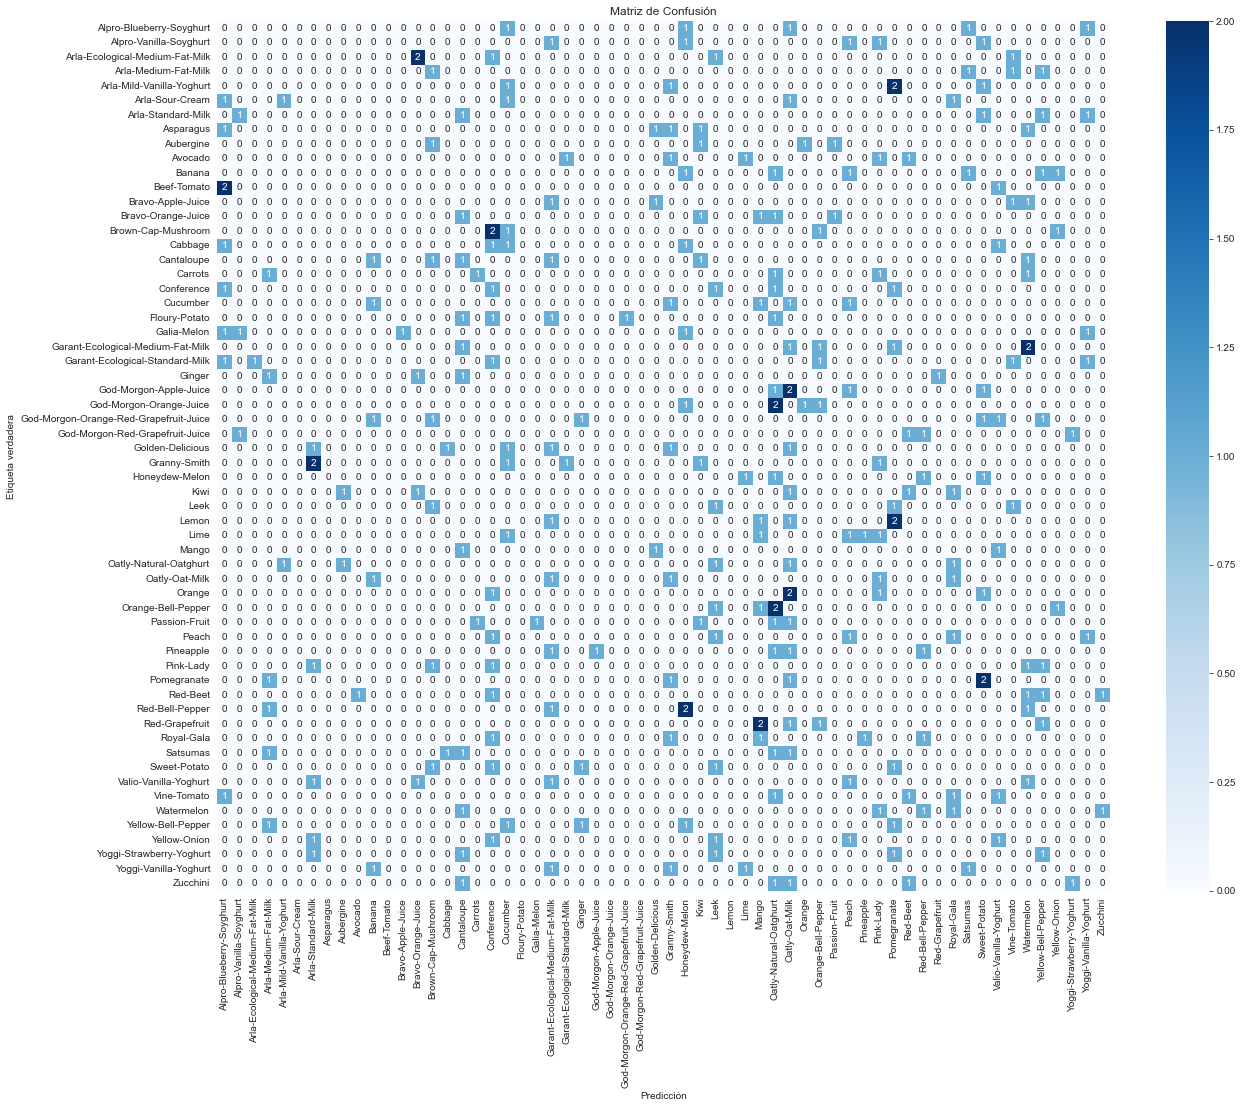

In [31]:
import seaborn as sns
pred_probabilities = modelo_baseline.predict(val_generator)  # Probabilidades predichas
y_pred = np.argmax(pred_probabilities, axis=1) 
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

### Modelo transfer

In [22]:
print("\nEvaluación del modelo Transfer Learning:")
transfer_eval = modelo_transfer.evaluate(test_generator)


Evaluación del modelo Transfer Learning:
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6380 - f1_score: 0.5997 - loss: 1.1139 - precision: 0.7682 - recall: 0.5384


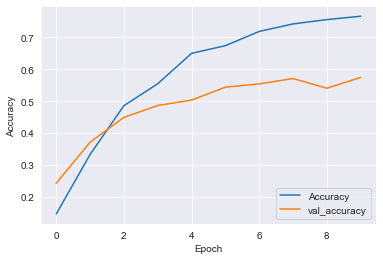

In [23]:
show_performance_curve(history_transfer, metric='accuracy', metric_label='Accuracy')

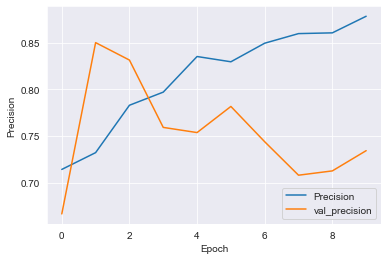

In [24]:
show_performance_curve(history_transfer, metric='precision', metric_label='Precision')

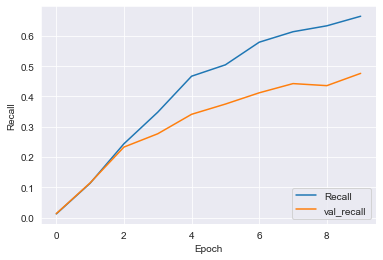

In [25]:
show_performance_curve(history_transfer, metric='recall', metric_label='Recall')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


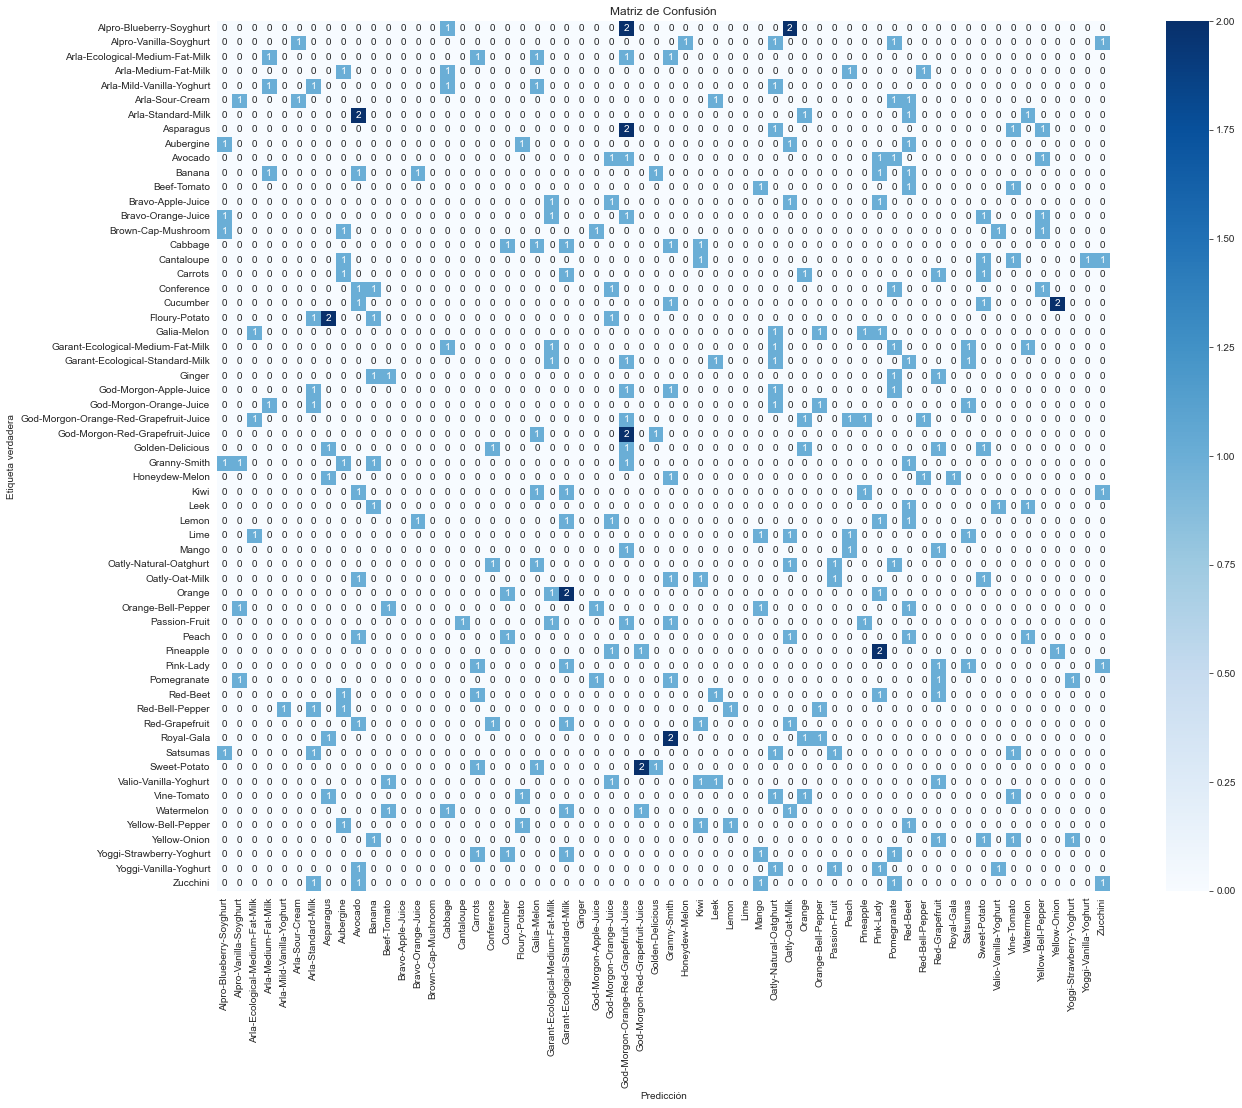

In [30]:
import seaborn as sns
pred_probabilities = modelo_transfer.predict(val_generator)  # Probabilidades predichas
y_pred = np.argmax(pred_probabilities, axis=1) 
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

## Productivización del modelo baseline

In [39]:
modelo_baseline.save('modelo_baseline_imagenes.keras')

In [40]:
modelo_baseline_cargado = tf.keras.models.load_model('modelo_baseline_imagenes.keras')

In [42]:
ruta_imagen = r'C:\Users\Esteban\Downloads\photo_2024-11-11_19-00-02.jpg'
image = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(128, 128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])

# Verificar la forma del lote de entrada
print("Forma del lote de entrada:", input_arr.shape)

# Realizar la predicción
predictions = modelo_baseline_cargado.predict(input_arr)
result_index = np.argmax(predictions)  # Obtener índice del valor máximo
print("Categoría predicha:", result_index)

Forma del lote de entrada: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Categoría predicha: 24


## Productivización del modelo transfer

In [27]:
modelo_transfer.save('modelo_clasificacion_imagenes.keras')

In [28]:
modelo_transfer_cargado = tf.keras.models.load_model('modelo_clasificacion_imagenes.keras')

In [29]:
# Cargar la imagen
ruta_imagen = r'C:\Users\Esteban\Downloads\photo_2024-11-11_19-00-02.jpg'
image = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(128, 128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr]) / 255.0  # Convertir la imagen a batch y normalizar

# Verificar la forma del lote de entrada
print("Forma del lote de entrada:", input_arr.shape)

# Realizar la predicción
predictions = modelo_transfer_cargado.predict(input_arr)
result_index = np.argmax(predictions)  # Obtener índice del valor máximo
print("Categoría predicha:", result_index)


Forma del lote de entrada: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Categoría predicha: 25
